In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gradio as gr
from PIL import Image, ImageTk
from faker import Faker
from transformers import pipeline
from keybert import KeyBERT

In [ ]:
kw_model = KeyBERT(model='all-mpnet-base-v2')

# Basic Dataset erstellen

3 Kategorien: Hotels, Restaurants & Aktivitäten

In [ ]:
df_rest = pd.read_csv('01_Data\dataset_Google-Maps-Reviews-Restaurants_2023-03-26_09-43-08-320.csv')
df_act = pd.read_csv('01_Data\dataset_Google-Maps-Reviews-Activities_2023-03-26_11-08-15-435.csv')
df_hotel = pd.read_csv('01_Data\dataset_Google-Maps-Reviews-Hotels_2023-03-26_11-34-16-492.csv')

print('Restaurants (Shape): ', df_rest.shape)
print('Activities (Shape): ', df_act.shape)
print('Hotels (Shape): ', df_hotel.shape)

In [ ]:
columns_to_keep = [
    "stars",
    "publishedAtDate",
    "name",
    "text",
    "title",
    "subTitle",
    "description",
    "price",
    "totalScore",
    "likesCount",
    "isLocalGuide",
    "reviewId",
    "categoryName",
    "reviewImageUrls/0",
    "reviewImageUrls/1",
    "reviewImageUrls/2",
    "reviewImageUrls/3",
    "reviewImageUrls/4",
    "reviewImageUrls/5",
    "reviewImageUrls/6",
    "reviewImageUrls/7",
    "reviewImageUrls/8",
    "reviewImageUrls/9",
    "reviewUrl",
    "reviewerId",
    "reviewerNumberOfReviews",
    "reviewerPhotoUrl",
    "reviewerUrl",
    "reviewsCount",
    "scrapedAt",
    "state",
    "street",
    "temporarilyClosed",
    "url",
    "website",

    # at least for restaurants
    "categories/0",
    "categories/1",
    "categories/2",
    "categoryName"
]

In [ ]:
df_rest = df_rest.dropna(subset=["reviewImageUrls/0"])
df_rest = df_rest[columns_to_keep]
df_rest['genre'] = 'restaurant'
print(df_rest.shape)

In [ ]:
df_act = df_act.dropna(subset=["reviewImageUrls/0"])
df_act = df_act[columns_to_keep]
df_act['genre'] = 'activity'
print(df_act.shape)

In [ ]:
df_hotel = df_hotel.dropna(subset=["reviewImageUrls/0"])
df_hotel = df_hotel[columns_to_keep]
df_hotel['genre'] = 'hotel'
print(df_hotel.shape)

In [ ]:
df = pd.concat([df_rest, df_act, df_hotel], ignore_index=True)
print(df.shape)
df.to_csv('all_rest_act_hotel.csv', index=False)

Resizing the images to 256-256 pixels via getting the better url & cheaper for Dall-E-API Nutzung

In [ ]:
image_urls_cols = [
    "reviewImageUrls/0",
    "reviewImageUrls/1",
    "reviewImageUrls/2",
    "reviewImageUrls/3",
    "reviewImageUrls/4",
    "reviewImageUrls/5",
    "reviewImageUrls/6",
    "reviewImageUrls/7",
    "reviewImageUrls/8",
    "reviewImageUrls/9"
]

for col in image_urls_cols:
    df[col] = df[col].str.replace("=w150-h150-k-no-p", "=w256-h256-p-k-no")

print(df.shape)

### Extract Keywords With KeyBert

In [ ]:
df['text'] = df['text'].astype(str)
print("Convertion done.")

df['keywords'] = df['text'].apply(lambda x: kw_model.extract_keywords(x,keyphrase_ngram_range=(1,1) ,
                                     stop_words='english', 
                                     highlight=False,
                                     top_n=5))
print("Keywords extraction done.")
df.to_csv('base_keywords_sentiment.csv', index=False)


### Sentiment analyse

In [ ]:
model_path = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
sentiment_task = pipeline("sentiment-analysis", model=model_path, tokenizer=model_path)

In [ ]:
df = pd.read_csv('base_keywords_sentiment.csv')
df['sentiment'] = np.nan
df['sentiment'] = df['sentiment'].astype(str)
df['text'] = df['text'].astype(str)
df['sent_score_0'] = np.nan

for idx, row in df.iterrows():
    try: 
        print("Processing row: ", idx)
        sentiment = sentiment_task(row['text'])
        df.at[idx, 'sentiment'] = sentiment
    except RuntimeError:
        print("Skipped due to messy data. Row: ", idx)
        pass
df.to_csv('base_keywords_sentiment.csv', index=False)

In [52]:
# df_neu = pd.read_csv('base_keywords_sentiment.csv')
# df_neu['sentiment'] = df_neu['sentiment'].astype(str)
# df_neu.to_csv('base_keywords_sentiment.csv', index=False)

In [53]:
# add a label column with all rows have real as value 

df['label'] = 'real'
print(df.shape)
df.to_csv('base_keywords_sentiment.csv', index=False)

(6869, 45)


In [ ]:
#only store the keywords in a list not the scores

# df['keywords_only'] = df['keywords'].apply(lambda x: [i[0] for i in x])
# print(df['keywords_only'])
# df.to_csv('base_keywords_sentiment.csv', index=False)

In [67]:
# how many rows have a less than 3 stars

df['stars'].value_counts()

5.0    4824
4.0    1320
3.0     379
1.0     206
2.0     140
Name: stars, dtype: int64

### Visualiserungen des Base-Dataset

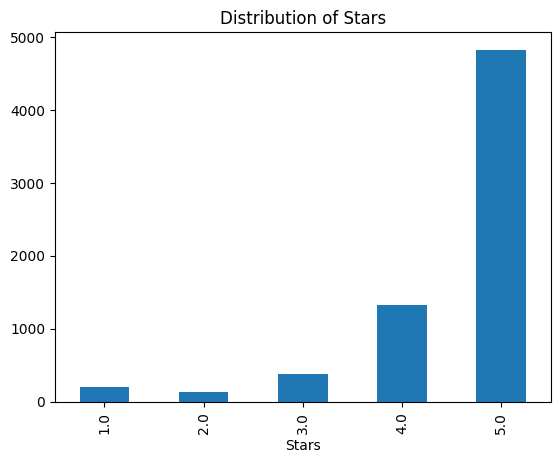

In [72]:
df['stars'].value_counts()

df['stars'].value_counts().sort_index().plot(kind='bar')
#set the title and labels
plt.title('Distribution of Stars')
plt.xlabel('Stars')
# save to C:\Users\michi\Documents\seminararbeit_review_detection\seminararbeit_review_detection\02_Visualizations

plt.savefig('stars_distribution.svg', dpi=300, bbox_inches='tight')

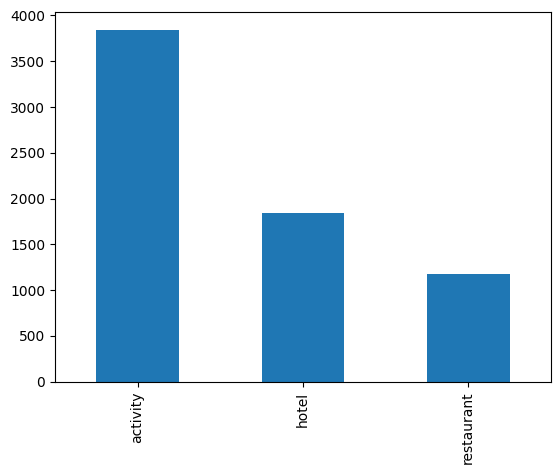

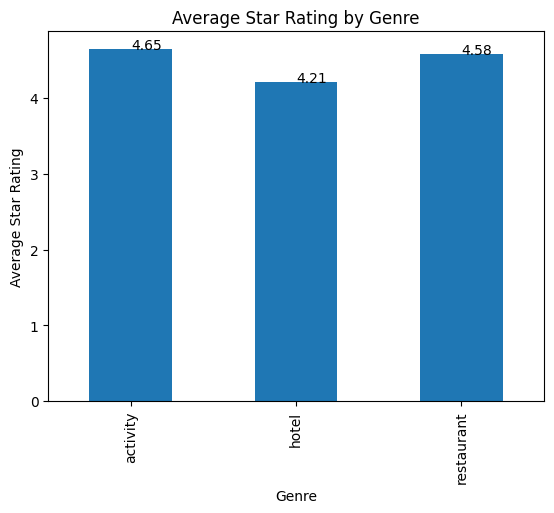

<Figure size 640x480 with 0 Axes>

In [73]:
df = pd.read_csv('base_keywords_sentiment.csv')
df['genre'].value_counts().plot(kind='bar')
plt.show()
# add titel and label 
plt.title('Distribution of Genre')
plt.xlabel('Genre')
plt.savefig('count_reviews_with_images_by_genre.png')

df.groupby('genre')['stars'].mean().plot(kind='bar')
for i, v in enumerate(df.groupby('genre')['stars'].mean().round(2)):
    plt.text(i, v, str(v), color='black')

plt.title('Average Star Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Star Rating')


plt.show()
plt.savefig('average_star_rating_by_genre.png')